In [1]:
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

import pandas as pd

import plotting_utils as pl

sc.set_figure_params(dpi=120)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from adjustText import adjust_text


In [2]:
cell_annot = '../data/global_clustering_obs.csv' # From global clustering script
cd4_8_classifications = '../data/ALLT_CD_classifications.txt' # From CD4/CD8 classification notebook
cell_cycle_annotations = '../data/T_cellcycle_annotations.csv' # From cell cycle notebook
granular_response_data = '../data/CART_granular_response.txt' # Clinical response data

In [3]:
obs = pd.read_csv(cell_annot,index_col=0)
obs['subtype']=pd.read_csv(cd4_8_classifications,sep='\t',index_col=0)['subtype']
obs = obs[~obs['subtype'].isna()] # Restrict to T-cells
obs.head()

,channel,barcode,timepoint,timepoint_fine,product,generic,nTisa,nAxi,CAR,n_genes_by_counts,total_counts,pct_counts_mt,response,cdr3_TRA,cdr3_TRB,leiden_1.0,leiden_1.5,leiden_2.0,cell_type,subtype
AAACCTGAGAAGATTC-1-0,20X,Axi-R-01,Infusion,Infusion,Yescarta,Axi-cel,0.0,3.0,True,2097,7592.0,9.101686,R,CAYRIPFGNEKLTF,CASSIVGIRATNEKLFF,10,10,13,Infusion T,CD8 T
AAACCTGAGAGCCTAG-1-0,20X,Axi-R-01,Infusion,Infusion,Yescarta,Axi-cel,0.0,0.0,False,2220,5289.0,3.308754,R,CAYNDYGGSQGNLIF,CASSVGTSGGTDTQYF,1,8,12,Infusion T,CD8 T
AAACCTGAGATTACCC-1-0,20X,Axi-R-01,Infusion,Infusion,Yescarta,Axi-cel,0.0,0.0,False,1098,2183.0,14.887770,R,CVVSDWSGNKLVF,CASREDGPSGANVLTF,2,0,10,Infusion T,CD4 T
AAACCTGAGCGATATA-1-0,20X,Axi-R-01,Infusion,Infusion,Yescarta,Axi-cel,0.0,0.0,False,1243,2598.0,8.814473,R,CILRDVGNAGNMLTF,CSASGLATNEKLFF,1,6,4,Infusion T,CD4 T
AAACCTGAGCTGGAAC-1-0,20X,Axi-R-01,Infusion,Infusion,Yescarta,Axi-cel,0.0,0.0,False,1090,2215.0,7.810384,R,CALSDGGGGADGLTF,CASSPGNTGELFF,10,10,13,Infusion T,CD4 T


In [4]:
obs['type']=obs['timepoint'].astype(str)
obs.loc[obs['CAR']&obs['timepoint'].str.match('D7'),'type'] = 'D7-CAR-T'
obs.loc[~obs['CAR']&(obs['timepoint']=="D7-CART"),'type'] = 'Unknown'
#adata.obs.loc[~adata.obs['cell_type'].str.match('.*T'),'type'] = 'Unknown'


### Figure 3a

In [5]:
C = pd.read_csv(granular_response_data,sep='\t')
C.head()

,Patient,timepoint,response
0,Tisa-N-28,30,NR
1,Tisa-N-25,27,NR
2,Tisa-N-23,28,NR
3,Tisa-N-24,31,NR
4,Tisa-N-31,29,NR


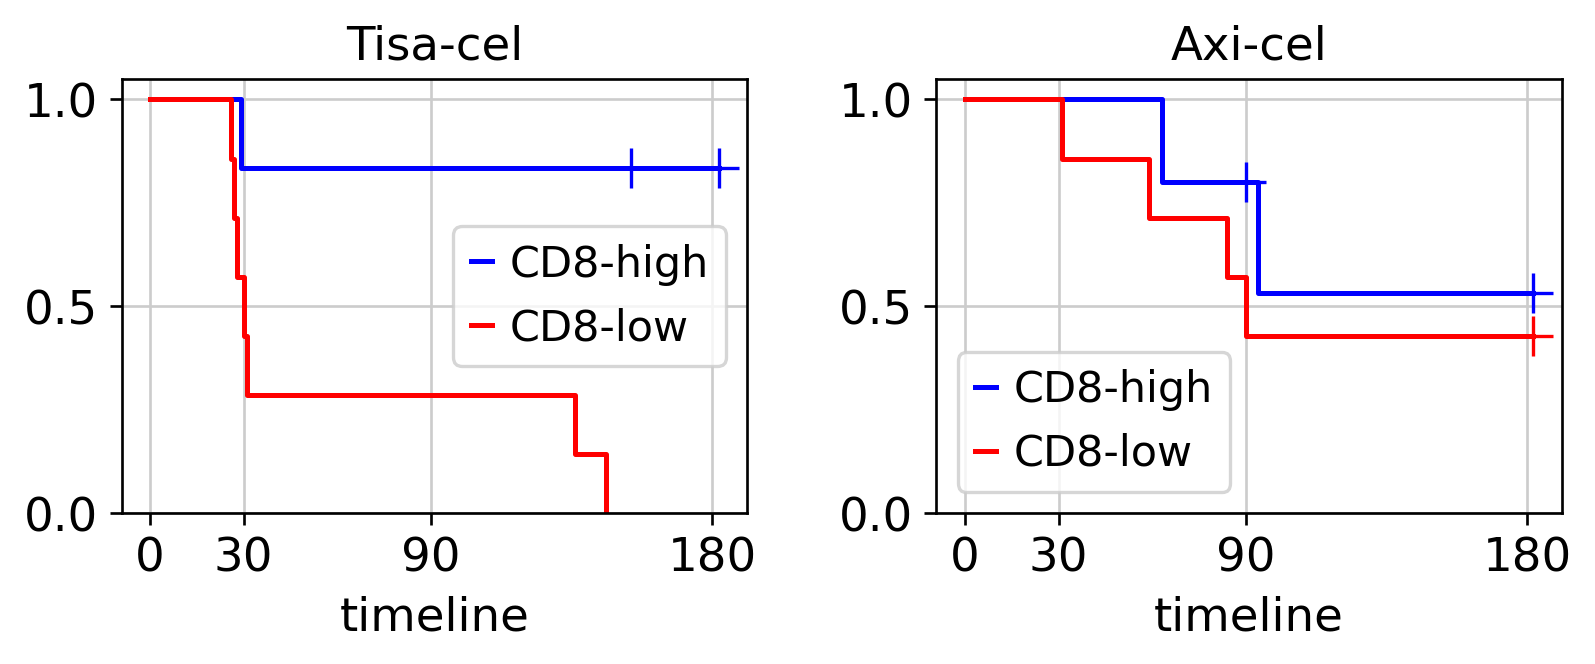

In [6]:
min_cells = 25

X = pd.crosstab([obs['type'],obs['barcode']],obs['subtype'])[['CD4 T','CD8 T']]
X.columns =X.columns.astype(str)
X['est'] = (X['CD8 T'])/(X['CD4 T'] + X['CD8 T'])
X['N'] = X['CD4 T'] + X['CD8 T']

X = X.loc['D7-CAR-T']

X = X[X['N']>=min_cells]

X = X.reset_index()

X=X.join(C.set_index('Patient'),on='barcode')

# Up to 6mo
X['timepoint']=np.minimum(182,X['timepoint'])

X = X[X['response']!="PR"]

X['product'] = X['barcode'].str.extract('(Tisa|Axi)')[0] + '-cel'

X['product'] = pd.Categorical(X['product'],categories=['Tisa-cel','Axi-cel'])

X['CD8-high'] = (X['est']>.5).astype(str)
X['CD8-type']=X['CD8-high'].map({"True":'CD8-high',"False":'CD8-low'})

f,ax = plt.subplots(1,2,figsize=(7,3))

palette = {'CD8-high':'blue','CD8-low':'red'}

i=0
for prod, g in X.groupby('product'):
    kmfs = list()
    for categ, g2 in g.groupby('CD8-type'):
        kmf = KaplanMeierFitter()

        kmf.fit(g2["timepoint"], g2["response"]=='NR', label=categ)
        kmf.plot_survival_function(ax=ax[i],
                                   show_censors=True,
                                   ci_show=False,
                                   iloc=slice(0,180),color=palette[categ])
        kmfs.append(kmf)
        

    ax[i].set_xticks([0,30,90,180])
        

    ax[i].set_title(prod)
    ax[i].set_ylim([0,1.05])
    

    i+=1
        
plt.tight_layout()

### Figure 3b

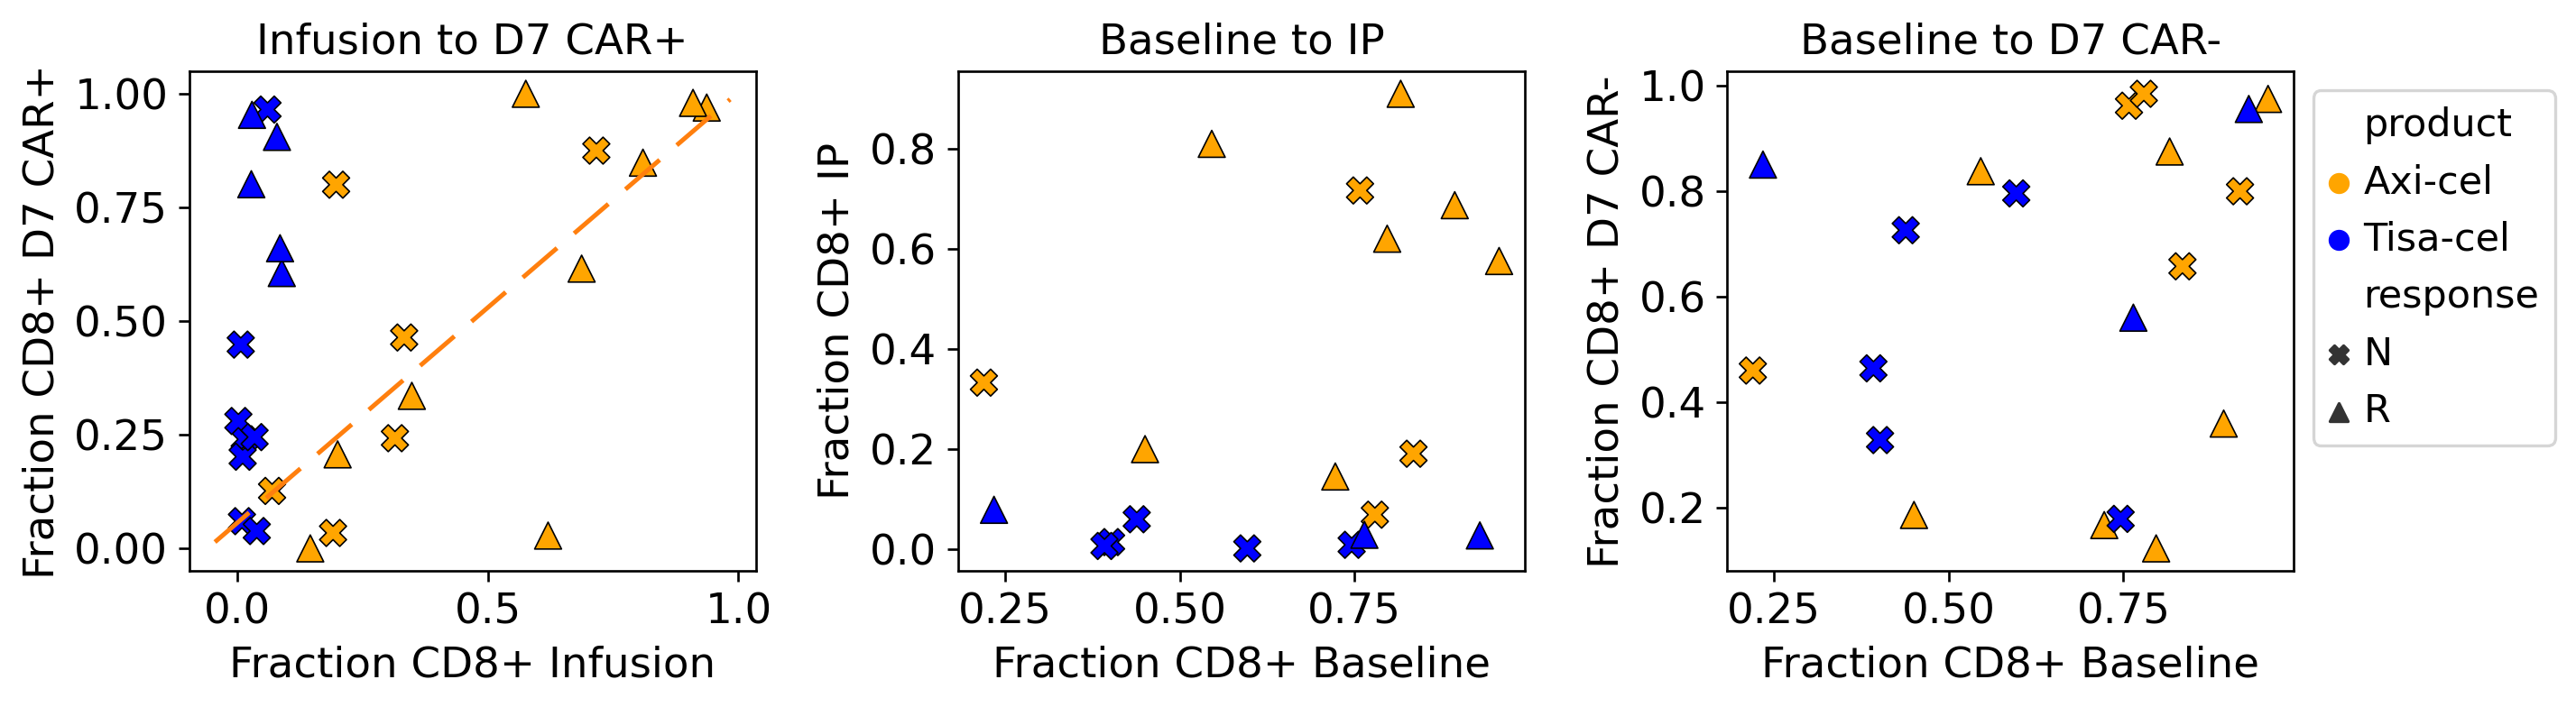

In [7]:
X = pd.crosstab([obs['type'],obs['product'],obs['barcode']],obs['subtype'])[['CD4 T','CD8 T']]
X.columns =X.columns.astype(str)
X['est'] = (X['CD8 T'])/(X['CD4 T'] + X['CD8 T'])

X = X.loc[['Infusion','Baseline','D7','D7-CAR-T']]

X = X.reset_index().astype({'type':str})

#X['product'] = X['barcode'].str.extract('^([^-]+)-')
X['response'] = X['barcode'].str.extract('^[^-]+-([^-]+)')[0].str.replace(' ','')
X['patient'] = X['barcode'].str.extract('^[^-]+-[^-]+-(.*)$')

X = X[X['response']!="nan"]

X['product']=X['product'].map({'Kymriah':'Tisa-cel','Yescarta':'Axi-cel'})

f,ax = plt.subplots(1,3,figsize=(12,3.5))

response_shapes = {'R':'^','N':'X'}
product_colors = {'Axi-cel':'orange','Tisa-cel':'blue'}


Xp = X.set_index(['barcode','product','response','type'])['est'].unstack().reset_index()
Xp = Xp[Xp['response']!="P"]


tp1s = ['Infusion','Baseline','Baseline']
tp2s = ['D7-CAR-T','Infusion','D7']
tp2_labels = ['D7 CAR+','IP','D7 CAR-']

for i in range(0,len(tp1s)):
    tp1=tp1s[i]
    tp2=tp2s[i]
    tp2label=tp2_labels[i]

    sns.scatterplot(tp1,tp2,data=Xp,hue="product",style='response',ax=ax[i],s=80,
                    markers=response_shapes,palette=product_colors,edgecolor='k',linewidth=.5)
    
    # Add bestfit line for tisa-cel
    if i==0:
        idx = (Xp['product']=='Axi-cel')&~Xp[tp1].isna()&~Xp[tp2].isna()
        a, b = np.polyfit(Xp.loc[idx,tp1], Xp.loc[idx,tp2], 1)
        xrange = np.linspace(ax[i].get_xlim()[0],ax[i].get_xlim()[1])
        ax[i].plot(xrange,a*xrange+b,color=sns.color_palette()[1],
                   linestyle="--",dashes=[10, 5])

    
    if i==2:
        ax[i].legend(bbox_to_anchor=(1,1))
    else:
        ax[i].legend().remove()

    ax[i].set_title(f'{tp1} to {tp2label}')
    ax[i].set_ylabel(f'Fraction CD8+ {tp2label}')
    ax[i].set_xlabel(f'Fraction CD8+ {tp1}')
    
    ax[i].grid(False)

plt.tight_layout()

### Figure 3c

In [8]:
obs['phase'] = pd.read_csv('../data/T_cellcycle_annotations.csv',index_col=0)['phase']

pcounts = pd.crosstab([obs['type'],obs['subtype'],obs['product'],obs['response'],obs['barcode']],obs['phase'])


In [9]:
fcyc = (1-(pcounts['G1']/pcounts.sum(axis=1))).reset_index().rename(columns={0:'frac'})
fcyc['N'] = pcounts.sum(axis=1).values

fcyc = fcyc[fcyc['N']>=50]

fcyc = fcyc[~fcyc['type'].str.match('Unknown')]

In [10]:
fcyc

,type,subtype,product,response,barcode,frac,N
0,Baseline,CD4 T,Kymriah,NR,Tisa-N-20,0.040587,1158
1,Baseline,CD4 T,Kymriah,NR,Tisa-N-23,0.094595,444
2,Baseline,CD4 T,Kymriah,NR,Tisa-N-24,0.078632,585
3,Baseline,CD4 T,Kymriah,NR,Tisa-N-25,0.010222,2250
4,Baseline,CD4 T,Kymriah,NR,Tisa-N-31,0.035325,1925
...,...,...,...,...,...,...,...
208,Infusion,CD8 T,Yescarta,R,Axi-R-17,0.775000,80
210,Infusion,CD8 T,Yescarta,R,Axi-R-02,0.494705,661
211,Infusion,CD8 T,Yescarta,R,Axi-R-04,0.444444,576
212,Infusion,CD8 T,Yescarta,R,Axi-R-01,0.727035,3821


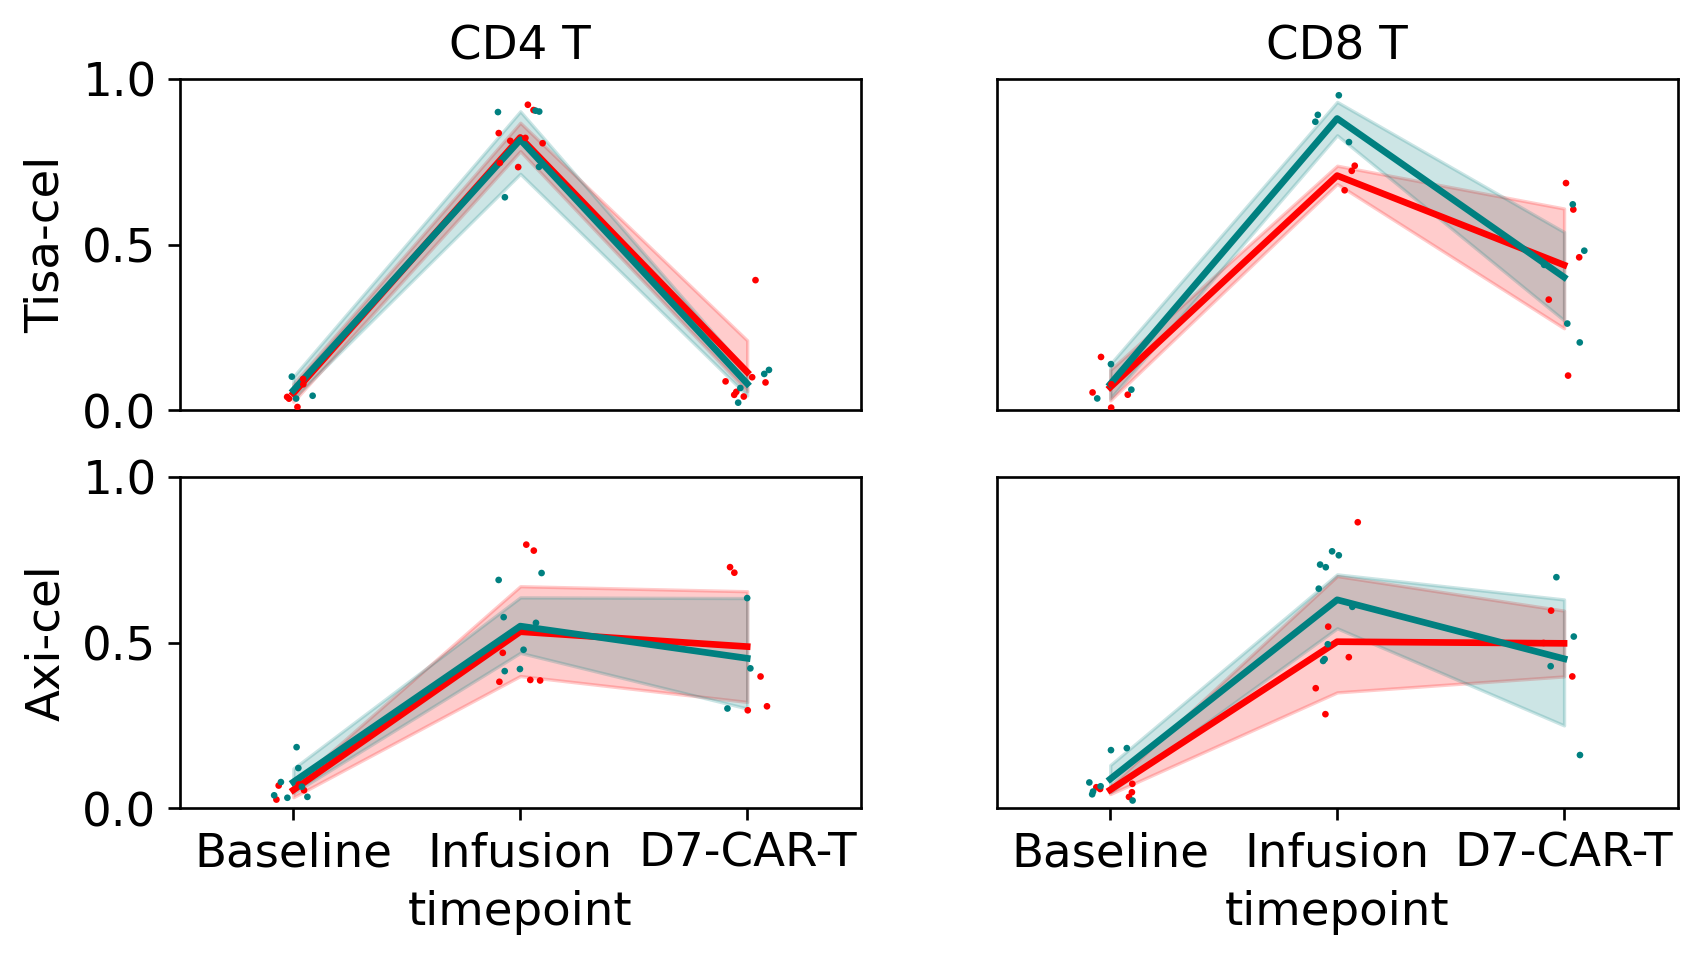

In [11]:
f,ax=plt.subplots(2,2,figsize=(8,4))
ax = ax.reshape(-1)

response_colors = {'R':'teal','NR':'red'}
generics = {'Kymriah':'Tisa-cel','Yescarta':'Axi-cel'}

i=0
for (prod,subtype), g in fcyc[fcyc['type']!="D7"].groupby(['product','subtype']):
    
    g['timepoint'] = pd.Categorical(g['type'],categories=["Baseline","Infusion","D7-CAR-T"])
    
    sns.lineplot('timepoint','frac',ax=ax[i],hue='response',data=g,legend=False,palette=response_colors,linewidth=2)
    
    stp = sns.stripplot('timepoint','frac',ax=ax[i],hue='response',data=g,s=2,palette=response_colors)
    stp.legend().remove()
    
    if i<2:
        ax[i].set_xticks([])
        ax[i].set_xlabel("")
        ax[i].set_title(subtype)
        
    if i%2==1:
        ax[i].set_yticks([])
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel(generics[prod])
    
    ax[i].set_ylim(0,1)
    ax[i].grid(False)
    i+=1

## Figure 3d

In [12]:
limma_res_dir = '../data/limma_results/limma_response_comparisons/'

In [13]:
volcano_response_palette = {'nonsignificant':'gray','up':'teal','down':[1,.25,0]}

Infusion
Kymriah
D7_CAR_T
Kymriah
Infusion
Yescarta
D7_CAR_T
Yescarta


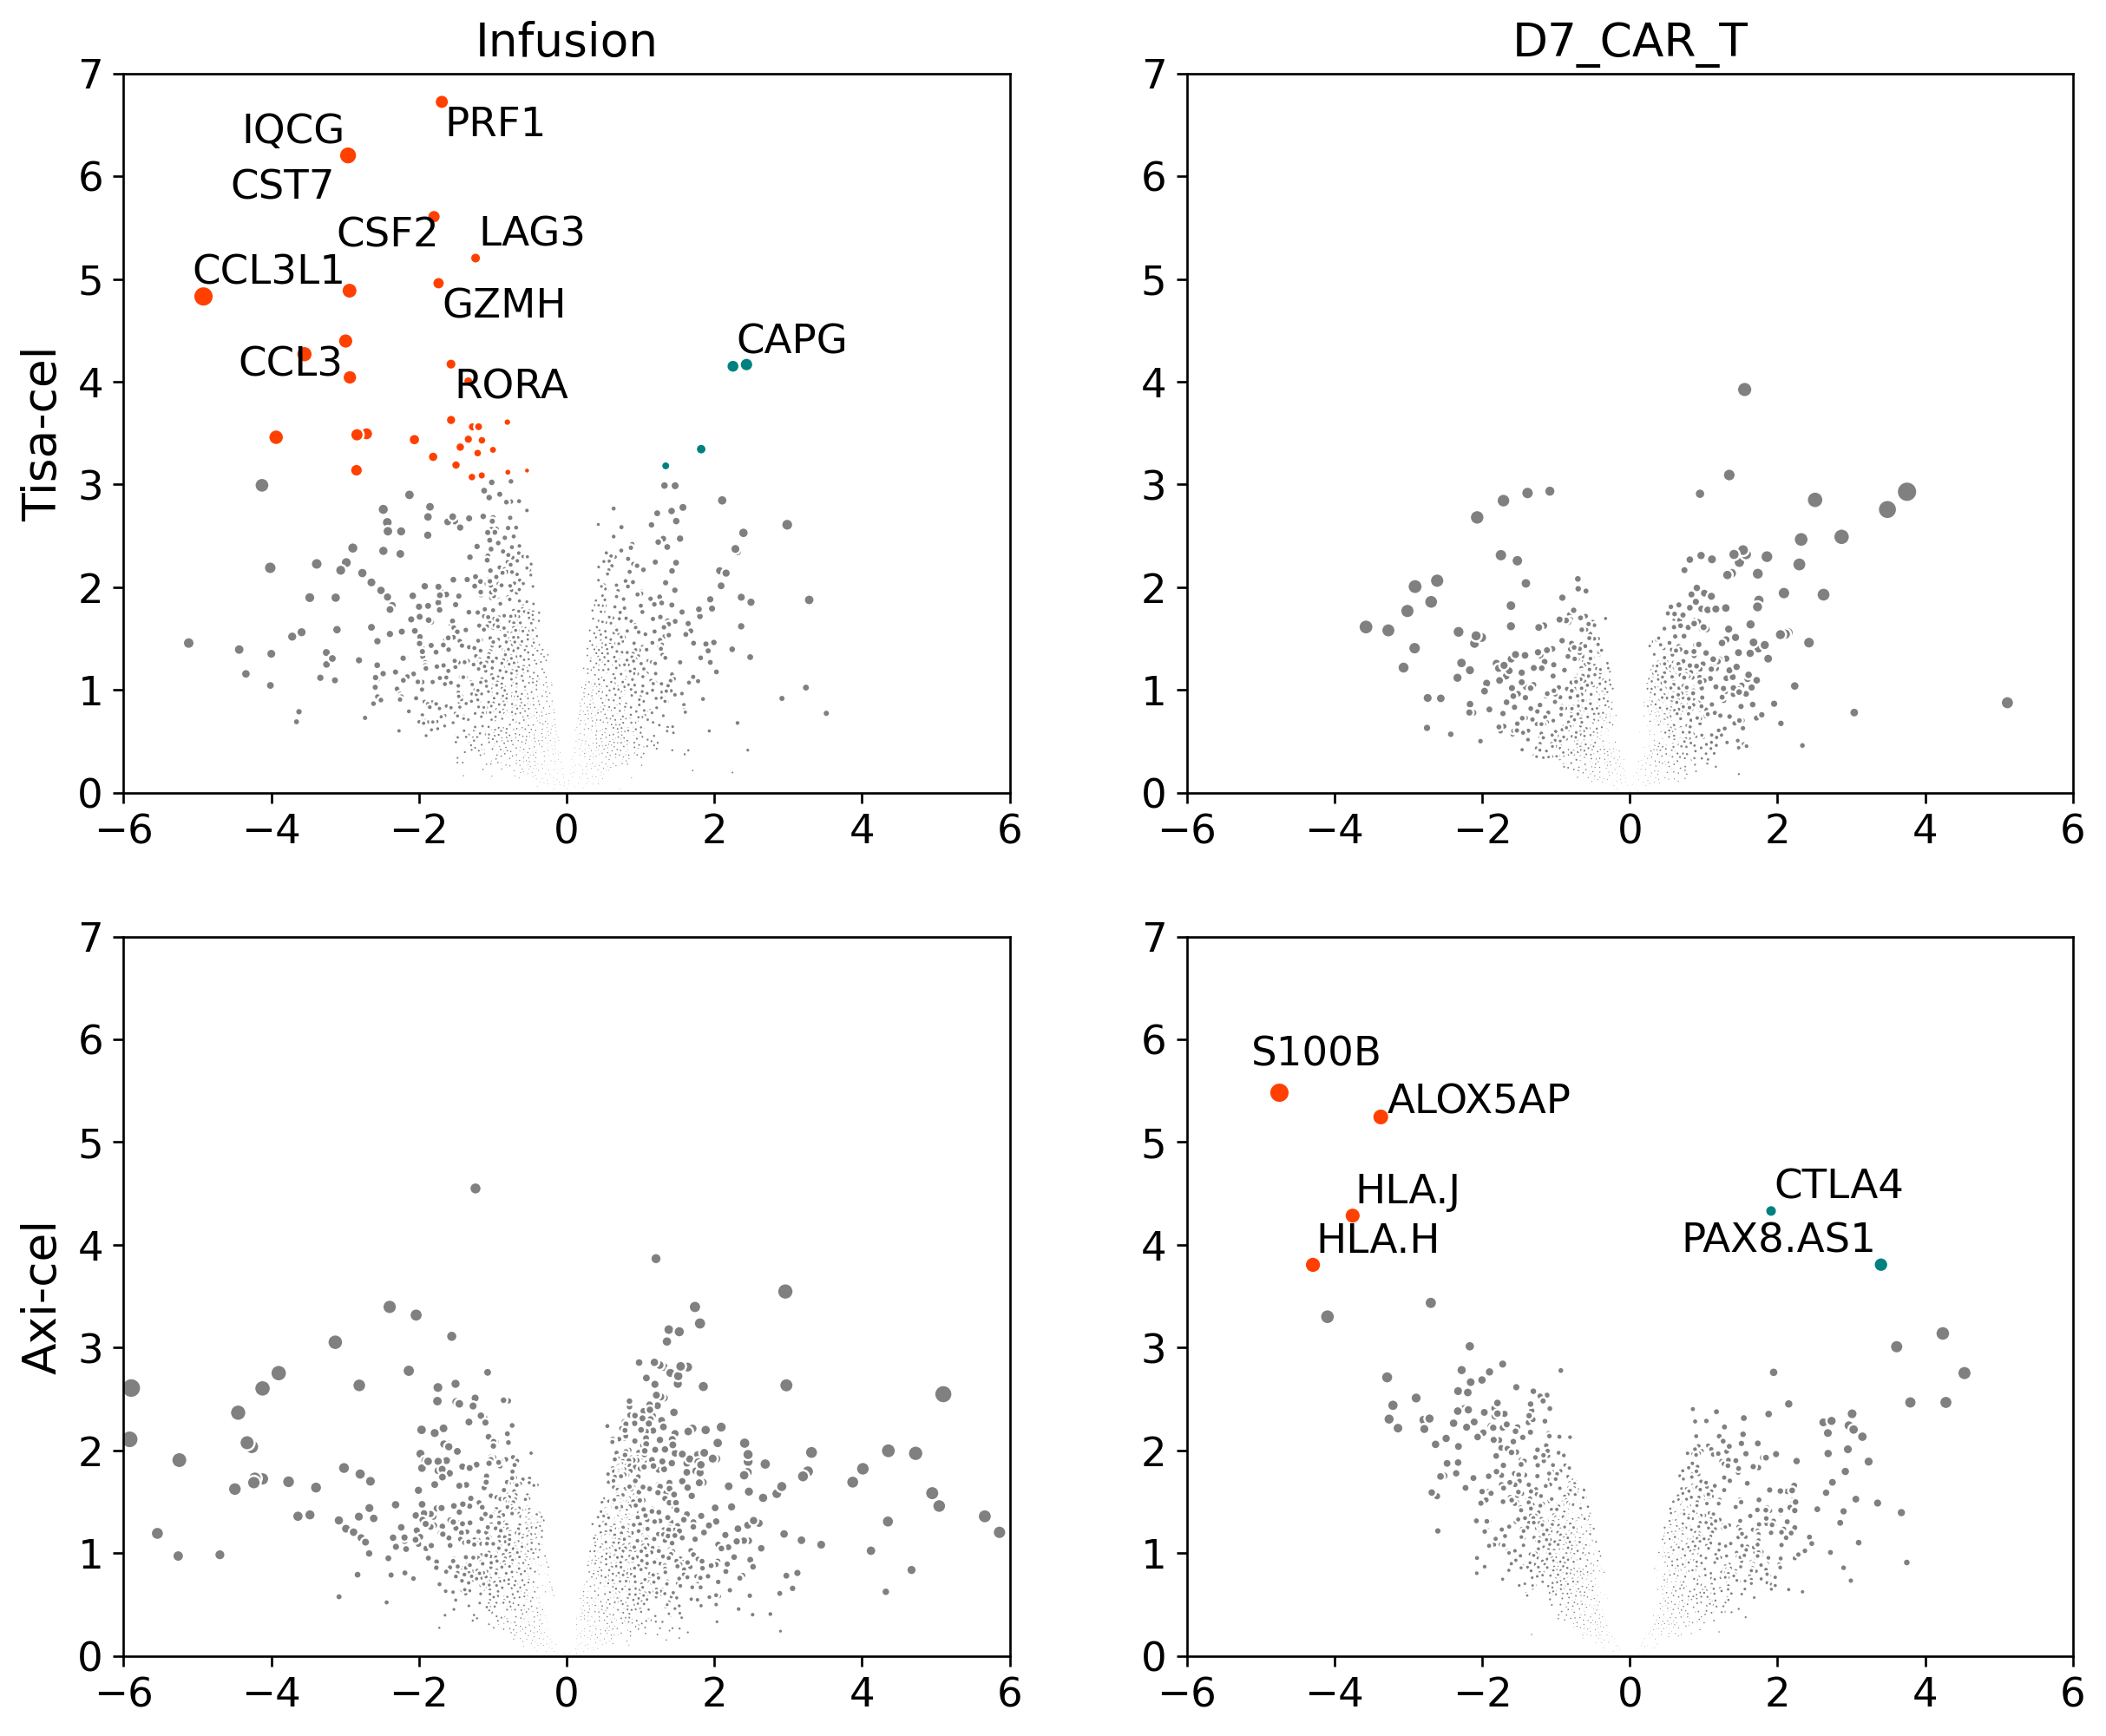

In [14]:
max_show=10

generics = {'Kymriah':'Tisa-cel','Yescarta':'Axi-cel'}

f,ax=plt.subplots(2,2,figsize=(12,10))
ax = ax.reshape(-1)
i=0
subtype='CD8'

text_list = list()

for product in ['Kymriah','Yescarta']:
    for timepoint in ['Infusion','D7_CAR_T']:

            print(timepoint)
            print(product)
            df = pd.read_csv(f'{limma_res_dir}/{timepoint}.{product}.{subtype}.csv',index_col = 0)
            df = df[~df.index.str.match('TR.V')]
            
            
            pl.volcano(df,ax=ax[i],label=False,palette = volcano_response_palette)
            
            ax[i].set_ylim(0,7)
            ax[i].set_xlim(-6,6)
            df['nlogp'] = np.minimum(10,-1*np.log10(df['P.Value']))

            texts = [ax[i].text(row['logFC'],row['nlogp'],gene) 
                     for gene,row in df[df['adj.P.Val']<.25].head(max_show).iterrows()]
            adjust_text(texts,ax=ax[i])
            
            #text_list.append(texts)
            if i<2:
                ax[i].set_title(timepoint,fontsize=16)
            if i%2==0:
                ax[i].set_ylabel(generics[product],fontsize=16)
            else:
                ax[i].set_ylabel('')
            ax[i].set_xlabel('')
            
            i+=1

### Figure 3e

In [15]:
obs = pd.read_csv('../data/T_subtype_knnclassifications.txt',sep='\t',index_col=0) ## Created in T-cell sorting notebook
obs.head()

,knnCD45RO,knnCD45RA,knnCCR7,knnFOXP3,knnCD4,knnCD8A,knnCD3D,knnKymriah,knnYescarta,class,subtype
AAACCTGAGAAGATTC-1-0,0.281148,0.075199,0.104050,0.538198,0.109266,1.824692,1.906889,0.000000,0.439730,EM,CD8 T
AAACCTGAGAAGGGTA-1-0,0.271361,0.006053,0.084154,0.000000,0.000000,2.170853,1.307871,0.000000,0.247276,EM,CD8 T
AAACCTGAGAGCCTAG-1-0,0.358544,0.060157,0.000000,0.000000,0.092981,2.303321,1.710876,0.000000,0.562398,EM,CD8 T
AAACCTGAGATTACCC-1-0,0.772339,0.002064,0.116655,0.093362,0.249245,0.146610,0.917061,0.000000,0.616288,EM,CD4 T
AAACCTGAGCGATATA-1-0,0.670741,0.000499,0.164206,0.064455,0.440964,0.158372,1.102742,0.029855,1.341415,EM,CD4 T


Text(-0.9, 1.5, '$T_{CM}$\n(CCR7+CD45RO+)')

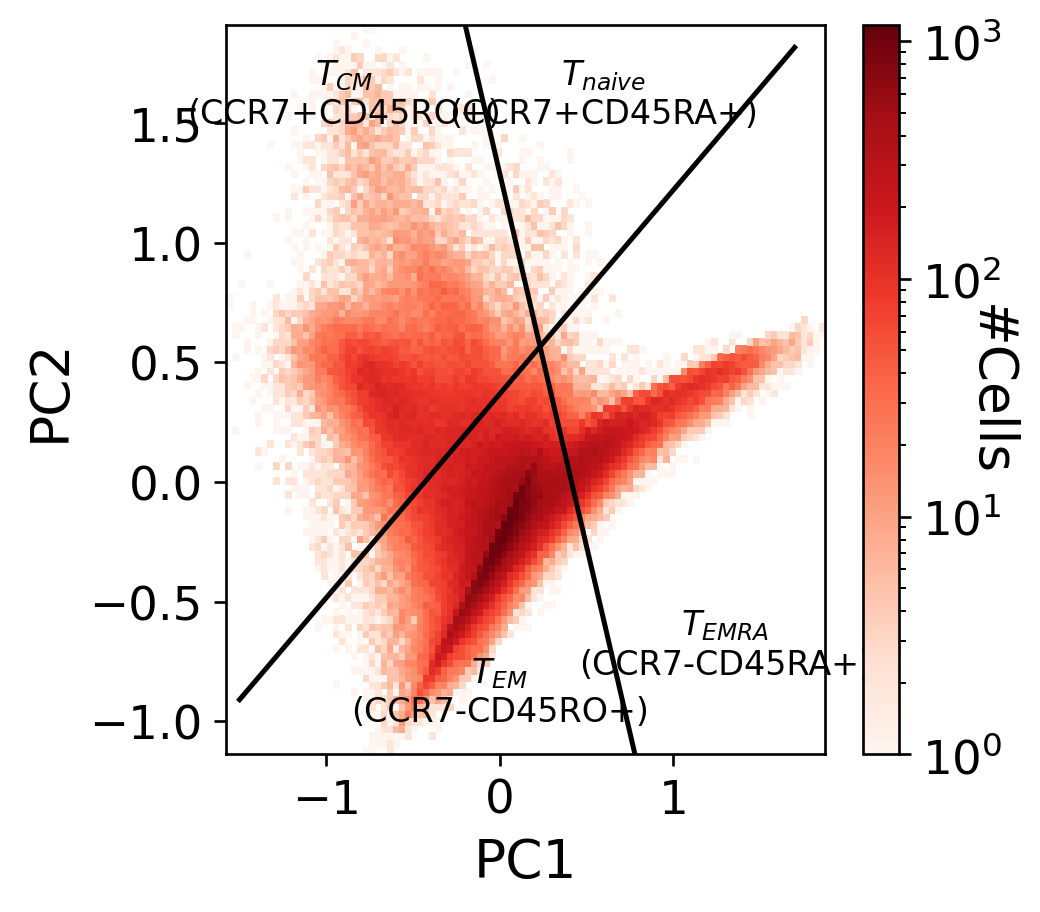

In [16]:
from sklearn.decomposition import PCA
pca = PCA(2)
PC = pca.fit_transform(obs[['knn'+g for g in ['CD45RA','CD45RO','CCR7']]])
obs['PC1'] = PC[:,0]
obs['PC2'] = PC[:,1]

import matplotlib as mpl

plt.hist2d(obs['PC1'],obs['PC2'],bins=100,cmap='Reds',norm=mpl.colors.LogNorm()
);


xplot = np.linspace(-1.5,1.7)
yplot = [-1*pca.components_[0,0]/pca.components_[1,0]*x+(.5-pca.mean_[0])/pca.components_[1,0] for x in xplot]

plt.plot(xplot,yplot,color='k')

yplot = [-1*pca.components_[0,2]/pca.components_[1,2]*x+(.5-pca.mean_[2])/pca.components_[1,2] for x in xplot]
plt.plot(xplot,yplot,color='k')


plt.xlabel('PC1',fontsize=16)
plt.ylabel('PC2',fontsize=16)
g=plt.colorbar()

g.set_label('#Cells',fontsize=16,rotation=-90)

fs=10
plt.text(1.3,-.8,'$T_{EMRA}$\n(CCR7-CD45RA+)',ha='center',fontsize=fs)
plt.text(0,-1,'$T_{EM}$\n(CCR7-CD45RO+)',ha='center',fontsize=fs)
plt.text(.6,1.5,'$T_{naive}$\n(CCR7+CD45RA+)',ha='center',fontsize=fs)
plt.text(-.9,1.5,'$T_{CM}$\n(CCR7+CD45RO+)',ha='center',fontsize=fs)

### Figure 3f

In [17]:
obs = pd.read_csv('gs://ibm-cart-0/analysis/may2021/ALLT_subtypes_annotated_obs.txt',
            sep='\t')

In [18]:
def calc_mean_fractions(obs,product,response,min_cells = 25):
    idx = (obs['product']==product)&(obs['response']==response)&(obs['subtype']!="Unknown")
    X = pd.crosstab([obs[idx]['subtype'],obs[idx]['class']],[obs[idx]['type'],obs[idx]['barcode']])
    
    keep_idx = X.sum(axis=0)>=min_cells
    X = X.loc[:,keep_idx]
    
    F = X/X.sum()
    F = pd.concat([F[tp].mean(axis=1) for tp in timepoints],axis=1)
    F.columns=timepoints
    return(F)

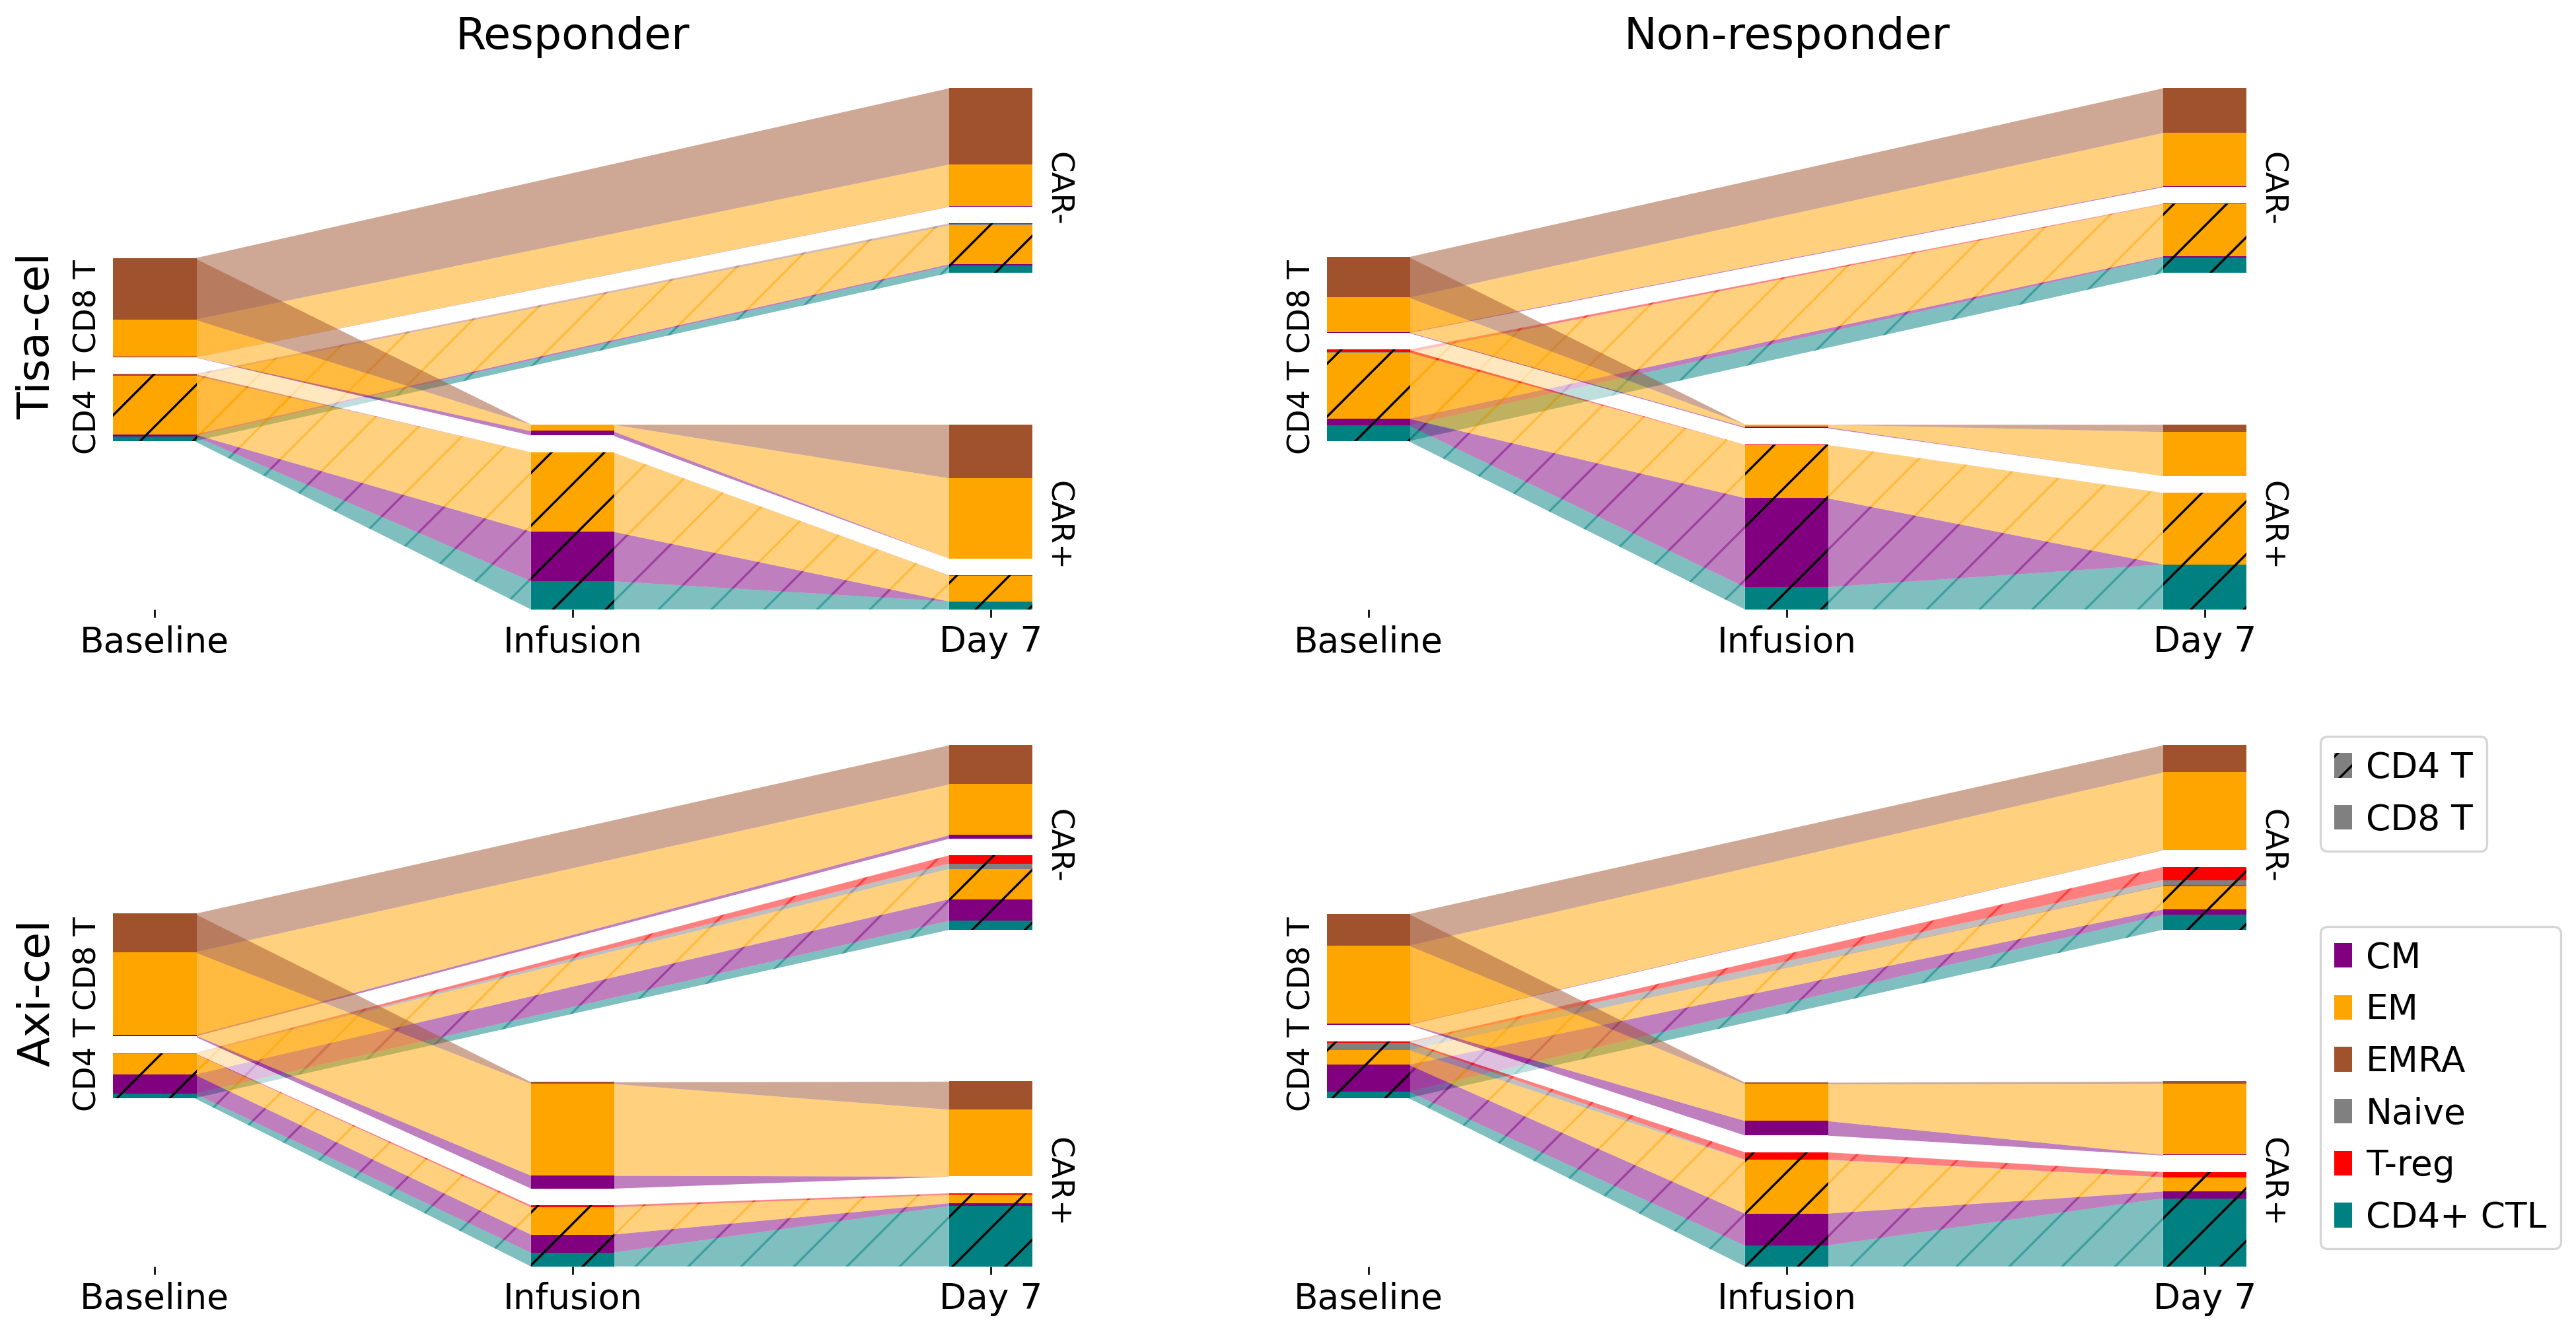

In [19]:
f,ax = plt.subplots(2,2,figsize=(18,10))
ax = ax.reshape(-1)
titles = {'R':'Responder','NR':'Non-responder'}
timepoints = ['Baseline','Infusion','D7-CAR-T','D7']

cd4_hatch = '/'
class_colors = {'CM':'blue','EM':'orange','EMRA':'red',
                    'Naive':'gray','T-reg':'green','CD4+ CTL':'teal'}

generics = {'Kymriah':'Tisa-cel','Yescarta':'Axi-cel'}

i=0
for product in ['Kymriah','Yescarta']:
    for response in ['R','NR']:
        
        F = calc_mean_fractions(obs,product,response)
        
        legend = i==3
        pl.evolution_plot(F,ax=ax[i],legend=legend,edge_alpha=.5,linewidth=0)
        
        if i<2:
            ax[i].set_title(titles[response],fontsize=20)
        if (i % 2) == 0:
            ax[i].set_ylabel(generics[product],fontsize=20)
            
        ax[i].grid(False)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        
        i+=1